### Download speeches

In [2]:
import urllib.request
import xml.etree.ElementTree as ET
import csv
import re
import sys
import matplotlib.pyplot as plt

TAG_RE = re.compile(r'<[^>]+>')
SPACE_RE = re.compile('&nbsp;')

In [94]:
import pandas as pd
import numpy as np

SENATOR_ID = 3398
MAX_SPEECHES = 300
f = urllib.request.urlopen("http://legis.senado.leg.br/dadosabertos/senador/"+ str(SENATOR_ID) +"/discursos")
raw = f.read()
root = ET.fromstring(raw)

print("Downloading speeches ")
parlamentar = root.find('Parlamentar')
i = 0

data = []

alltexts = ''
with open("output/senator-speeches.csv", "w", encoding='utf-8') as ofile:
    writer = csv.writer(ofile, delimiter=',', quotechar='"', quoting=csv.QUOTE_ALL)
    id = parlamentar.find("IdentificacaoParlamentar")
    for pr in parlamentar.find("Pronunciamentos").iter('Pronunciamento'):
        i = i + 1
        try:
    #         http://www25.senado.leg.br/web/atividade/pronunciamentos/-/p/texto/427686
            urlTexto = pr.find('UrlTexto').text
            f = urllib.request.urlopen(urlTexto)
            html = f.read().decode('utf-8')
    #         print('>>>' + html)

            html_frag = re.search('texto-integral">(.*)<div class="FooterMain"', html)
            if html_frag != None:
                text = TAG_RE.sub('', html_frag.group(1))
                text = SPACE_RE.sub('', text)
        #         print(text)

                row = [ id.find('CodigoParlamentar').text,
                        id.find('NomeParlamentar').text,
                        id.find('SexoParlamentar').text,
                        pr.find('SiglaTipoPronunciamento').text,
                        pr.find('DataPronunciamento').text,
                        pr.find('SiglaPartidoParlamentarNaData').text,
                        pr.find('UfParlamentarNaData').text,
                        pr.find('NomeCasaPronunciamento').text,
                        text,
                      ]
                writer.writerow(row)
        #         print('>>>> ' + text)
                alltexts = alltexts + '\n' + text
                data.append(text)
        #         print("speech " + row[1] + " " + row[4])
                sys.stdout.write('.')
            else:
                print("Unavailable " + urlTexto)

            if i > MAX_SPEECHES:
                break
        except Exception as e:
            print('exception ' + str(e))
            if i > MAX_SPEECHES:
                break

speeches = data

print("Done")

..................exception <urlopen error [Errno 111] Connection refused>
.................................................................................................................................................................................................................................................................................Unavailable http://www25.senado.leg.br/web/atividade/pronunciamentos/-/p/texto/375760
Unavailable http://www25.senado.leg.br/web/atividade/pronunciamentos/-/p/texto/375764
.......Done


### Cleanup and tokenize documents words

In [117]:
import nltk
import re
from nltk.corpus import floresta
from nltk.stem import SnowballStemmer

stopwords = list(set([line.strip() for line in open('stopwords.txt', 'r', encoding='utf-8')]))

nouns = []
tsents = floresta.tagged_sents()
for sent in tsents:
    for (w,t) in sent:
        if t=='H+n':
            nouns.append(w.lower())
            
#documents - [string contents]
def tokenize_filter_stem(documents, stopwords=[], word_min_size=3, word_filter_regex='.*', stemmer_language=None, only_nouns=False):
    stemmer = None
    if stemmer_language != None:
        stemmer = SnowballStemmer(stemmer_language)
    def stem(word):
        if stemmer != None:
            return stemmer.stem(word)
        else:
            return word
    tokens = [nltk.word_tokenize(s.lower()) for s in documents]
    tokens = [[stem(t) for t in tt if (only_nouns==False or t in nouns) and ((len(t)>=word_min_size) and (t not in stopwords) and (re.match(word_filter_regex, t)))] for tt in tokens]
    return tokens

parei aqui... isnouns muito pesado

In [118]:
tokens = tokenize_filter_stem(speeches, stopwords, word_min_size=3, word_filter_regex='[a-z]', stemmer_language='portuguese', only_nouns=True)
# tokens = tokenize_filter_stem(speeches, stopwords, word_min_size=2, word_filter_regex='[a-z]')
print([len(a) for a in tokens])

[19, 391, 422, 569, 424, 91, 698, 727, 324, 259, 355, 185, 21, 275, 19, 501, 193, 223, 766, 220, 110, 17, 375, 407, 210, 289, 344, 298, 15, 295, 187, 386, 238, 120, 256, 243, 95, 286, 199, 86, 143, 582, 56, 291, 402, 23, 588, 324, 434, 289, 352, 357, 278, 317, 136, 367, 151, 233, 285, 388, 320, 429, 643, 154, 217, 20, 124, 272, 150, 367, 403, 54, 451, 295, 146, 268, 7, 338, 440, 254, 50, 18, 369, 582, 346, 103, 454, 249, 137, 73, 436, 234, 375, 11, 356, 208, 287, 177, 99, 197, 349, 374, 284, 410, 33, 122, 311, 576, 82, 368, 28, 137, 542, 287, 366, 717, 180, 440, 429, 333, 387, 354, 366, 98, 700, 325, 484, 252, 377, 279, 256, 431, 194, 137, 950, 621, 346, 443, 30, 98, 1075, 532, 44, 275, 554, 810, 557, 410, 568, 94, 177, 438, 304, 280, 283, 375, 194, 717, 330, 115, 777, 252, 105, 13, 333, 462, 496, 477, 146, 29, 322, 262, 59, 294, 43, 554, 454, 410, 321, 375, 272, 485, 172, 210, 694, 589, 481, 429, 690, 380, 388, 512, 643, 851, 132, 502, 20, 51, 221, 11, 571, 178, 209, 440, 138, 342, 29

In [119]:
from wordcloud import WordCloud

def plot_word_cloud(words):
    text = ''
    text = ' '.join(list(words))
    wordcloud = WordCloud(max_font_size=40, random_state=42).generate(text)
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

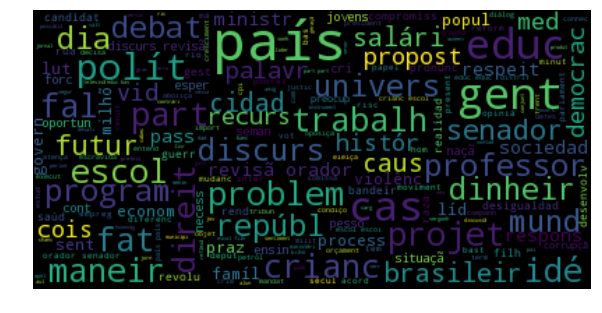

In [120]:
tt = []
for t in tokens:
    for a in t:
        tt.append(a)
plot_word_cloud(tt)

### Explore LDA topic modeling

In [121]:
import gensim
from gensim import corpora, models

In [122]:
dictionary = corpora.Dictionary(tokens)
corpus = [dictionary.doc2bow(text) for text in tokens]
lda_model = gensim.models.ldamodel.LdaModel(corpus, num_topics=4, id2word=dictionary, passes=100)
print(lda_model)

LdaModel(num_terms=2712, num_topics=4, decay=0.5, chunksize=2000)


In [123]:
lda_model.print_topics(5)
# vis_data = gensimvis.prepare(lda_model, tokens, dictionary)
# pyLDAvis.display(vis_data)

[(0,
  '0.026*"educ" + 0.026*"salári" + 0.016*"dinheir" + 0.015*"país" + 0.015*"trabalh" + 0.013*"polít" + 0.013*"program" + 0.010*"cas" + 0.010*"bilhõ" + 0.010*"direit"'),
 (1,
  '0.031*"escol" + 0.031*"crianc" + 0.022*"país" + 0.017*"educ" + 0.016*"violênc" + 0.013*"problem" + 0.012*"aboliçã" + 0.012*"filh" + 0.011*"cas" + 0.009*"petról"'),
 (2,
  '0.038*"educ" + 0.029*"escol" + 0.027*"país" + 0.027*"professor" + 0.022*"univers" + 0.016*"gent" + 0.013*"futur" + 0.013*"ensin" + 0.012*"revolu" + 0.009*"cidad"'),
 (3,
  '0.025*"país" + 0.020*"part" + 0.019*"polít" + 0.016*"cas" + 0.016*"gent" + 0.011*"discurs" + 0.010*"democrac" + 0.010*"repúbl" + 0.009*"senador" + 0.008*"projet"')]